## Load Dependencies

In [3]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import pickle
from sklearn import tree

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import optuna


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Projects/TweetClassification')

Mounted at /content/drive


## Retrieving and Exploring Data

In [5]:
# Download from Kaggle
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

100%|██████████| 80.9M/80.9M [00:03<00:00, 21.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


In [6]:
# Load into dataframe
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

dataset_path = os.path.join(path, "training.1600000.processed.noemoticon.csv")
df = pd.read_csv(dataset_path, encoding = "latin1", names=columns)

print(df.shape)
df.head(5)

(1600000, 6)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)
df.head(5)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
df['target'] = df['target'].replace(4, 1)

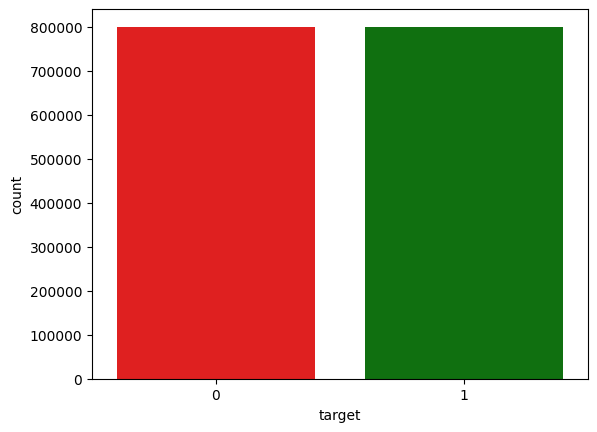

In [9]:
sns.countplot(data= df, x = 'target', palette = ["red", "green"], hue='target', legend=False)
plt.show()

## Text Pre-Processing

In [10]:
stopwords = set(stopwords.words('english'))

In [11]:
ps = PorterStemmer()
corpus = []

for text in df['text']:
    text = re.sub(r'http[s]?://\S+', ' ', text)
    text = re.sub('@\S+', '', text)
    text = re.sub('[^A-Za-z]', ' ', text)

    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stopwords]
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)

    corpus.append(text)

Maybe don't remove punctuation

## Feature Extraction

In [ ]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
# X = vectorizer.fit_transform(corpus)

In [ ]:
# with open('vectorizer.pkl', 'wb') as file:
#     pickle.dump(vectorizer, file)

In [12]:
vectorizer = pickle.load(open('vectorizer.pkl','rb'))
X = vectorizer.transform(corpus)

In [13]:
X.shape # Each row is a document (tweet) and each column is a word/pair of words

(1600000, 500000)

In [14]:
y = df['target']
y.shape

(1600000,)

## Model Training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [16]:
print(f"X Train: {X_train.shape}")
print(f"y Train: {y_train.shape}")
print(f"X Test: {X_test.shape}")
print(f"y Test: {y_test.shape}")

X Train: (1200000, 500000)
y Train: (1200000,)
X Test: (400000, 500000)
y Test: (400000,)


In [17]:
def train_model(model, X_train, y_train):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print("Confusion matrix: \n",confusion_matrix(y_pred,y_test))
  print("Accuracy score: ",accuracy_score(y_pred,y_test))
  print("Classification Report: \n",classification_report(y_pred,y_test))

In [35]:
model1 = SGDClassifier(loss='log_loss', max_iter=500)
model2 = BernoulliNB()
model3 = MultinomialNB()
model4 = LogisticRegression(max_iter=500)
model5 = LinearSVC(max_iter=500)
models = [model1, model2, model3, model4, model5]

In [36]:
i = 1
for model in models:
  print("Model:",i)
  train_model(model, X_train, y_train)
  print("-----------------------------------------------------------\n")
  i += 1

Model: 1
Confusion matrix: 
 [[147350  44905]
 [ 52899 154846]]
Accuracy score:  0.75549
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.77      0.75    192255
           1       0.78      0.75      0.76    207745

    accuracy                           0.76    400000
   macro avg       0.76      0.76      0.76    400000
weighted avg       0.76      0.76      0.76    400000

-----------------------------------------------------------

Model: 2
Confusion matrix: 
 [[150974  40333]
 [ 49275 159418]]
Accuracy score:  0.77598
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.79      0.77    191307
           1       0.80      0.76      0.78    208693

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000

---------------------------------------------------------

Logistic Regression was the best performer, will tune its parameters

## Hyperparameter Tuning using Optuna

In [31]:
def objective(trial):

    C = trial.suggest_float('C', 0.5, 2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    model = LogisticRegression(C=C, penalty=penalty, solver=solver)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred,y_test)

    return accuracy

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs = 8)

[I 2025-02-04 20:01:39,893] A new study created in memory with name: no-name-2da7aad4-914f-458e-9164-d10c9b461e3f
[I 2025-02-04 20:02:52,584] Trial 0 finished with value: 0.7899275 and parameters: {'C': 0.6705310959528664, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7899275.
[I 2025-02-04 20:03:21,605] Trial 4 finished with value: 0.7901125 and parameters: {'C': 1.7417620987814164, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 4 with value: 0.7901125.
[I 2025-02-04 20:03:25,776] Trial 6 finished with value: 0.7903025 and parameters: {'C': 1.5493497553905464, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 6 with value: 0.7903025.
[I 2025-02-04 20:03:26,496] Trial 2 finished with value: 0.7906 and parameters: {'C': 1.231071404112785, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.7906.
[I 2025-02-04 20:03:28,634] Trial 5 finished with value: 0.7905825 and parameters: {'C': 1.2155246633746346, 'penalty': 'l2', 'solver': '

In [37]:
study.best_params

{'C': 1.2018152012730499, 'penalty': 'l2', 'solver': 'liblinear'}

In [38]:
best_model = LogisticRegression(**study.best_params)
train_model(best_model, X_train, y_train)

Confusion matrix: 
 [[154067  37560]
 [ 46182 162191]]
Accuracy score:  0.790645
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.80      0.79    191627
           1       0.81      0.78      0.79    208373

    accuracy                           0.79    400000
   macro avg       0.79      0.79      0.79    400000
weighted avg       0.79      0.79      0.79    400000



In [39]:
with open("model.pkl","wb") as file:
  pickle.dump(model,file)